#### Exercise 2: CNN on MNIST and SVNH

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models
import torchvision.transforms as transforms
import numpy as np
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt

Importing MNIST dataset

In [ ]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_data, val_data = torch.utils.data.random_split(train_data, [48000, 12000])
test_data = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=4, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=False, num_workers=2)

In [ ]:
test_data

10000

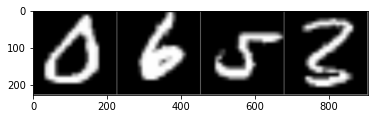

tensor(0) tensor(6) tensor(5) tensor(3)


In [ ]:
#Function to show some random images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

#Get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

#Show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j] for j in range(4)))

Use untrained ResNet

In [ ]:
# loading model from torchvision
resnet18 = models.resnet18(pretrained=False, progress=True)

# modify the input layer to take 1 channel instead of 3
resnet18.conv1 = nn.Conv2d(
    in_channels=1,
    out_channels=64,
    kernel_size=(7,7),
    stride=(2,2),
    padding=(3,3),
    bias=False
)

# modify FC to fit MNIST dataset
resnet18.fc = nn.Linear(512, 10, bias=True)

#Instantiating CUDA device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Verifying CUDA
print(device)

#Move the input and ResNet to GPU for speed if available
resnet18.to(device)

cuda:0


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Loss function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)

# hyperparameters
epochs = 10

Train the untrained ResNet

In [ ]:
# set writer for tensorboard
writer = SummaryWriter("/content/drive/MyDrive/D7047E - ADL/runs2")

# Training
for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for batch_index, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = resnet18(inputs)
        loss = criterion(output, labels)
        writer.add_scalar("Loss/train_untrained", loss, epoch)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if batch_index % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, batch_index + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training of ResNet')
writer.flush()
writer.close()

[1,  2000] loss: 0.740
[1,  4000] loss: 0.188
[1,  6000] loss: 0.142
[1,  8000] loss: 0.111
[1, 10000] loss: 0.091
[1, 12000] loss: 0.074
[2,  2000] loss: 0.067
[2,  4000] loss: 0.060
[2,  6000] loss: 0.057
[2,  8000] loss: 0.062
[2, 10000] loss: 0.054
[2, 12000] loss: 0.053
[3,  2000] loss: 0.042
[3,  4000] loss: 0.043
[3,  6000] loss: 0.039
[3,  8000] loss: 0.034
[3, 10000] loss: 0.038
[3, 12000] loss: 0.034
[4,  2000] loss: 0.029
[4,  4000] loss: 0.030
[4,  6000] loss: 0.030
[4,  8000] loss: 0.031
[4, 10000] loss: 0.026
[4, 12000] loss: 0.029
[5,  2000] loss: 0.018
[5,  4000] loss: 0.020
[5,  6000] loss: 0.021
[5,  8000] loss: 0.023
[5, 10000] loss: 0.018
[5, 12000] loss: 0.021
[6,  2000] loss: 0.017
[6,  4000] loss: 0.022
[6,  6000] loss: 0.016
[6,  8000] loss: 0.013
[6, 10000] loss: 0.016
[6, 12000] loss: 0.013
[7,  2000] loss: 0.012
[7,  4000] loss: 0.011
[7,  6000] loss: 0.015
[7,  8000] loss: 0.017
[7, 10000] loss: 0.014
[7, 12000] loss: 0.012
[8,  2000] loss: 0.011
[8,  4000] 

Evaluate ResNet on MNIST

In [ ]:
#Testing Accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 99 %


In [ ]:
#Validation Accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in val_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 validation images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 validation images: 99 %


In [ ]:
# save the trained wieghts of ResNet on MNIST
torch.save(resnet18.state_dict(), "/content/drive/MyDrive/D7047E - ADL/ResNetMNIST.pt")